# Seoul Bike Sharing Dataset (따릉이 데이터)

이 데이터는 **시간별 따릉이 대여 건수**를 예측하기 위한 회귀 데이터 셋입니다.  
총 **특성(Features) 12개**와 목표 변수(Target) 1개로 구성되어 있습니다.

---

## Target (예측 대상)
- **Rented.Bike.Count** : 시간별 따릉이 대여 건수

---

## 주요 Features (설명 변수)

- **Hour** : 하루 시간 (0 ~ 23시)  
- **Temperature (°C)** : 기온  
- **Humidity (%)** : 습도  
- **Windspeed (m/s)** : 풍속  
- **Visibility (10m)** : 가시거리  
- **Dew.point.temperature (°C)** : 이슬점 온도  
- **Solar.Radiation (MJ/m2)** : 일사량  
- **Rainfall (mm)** : 강수량  
- **Snowfall (cm)** : 적설량  
- **Seasons** : 계절 (1: 봄, 2: 여름, 3: 가을, 4: 겨울)  
- **Holiday** : 공휴일 여부 (0: 평일, 1: 공휴일)  
- **Functioning.Day** : 운행일 여부 (Yes/No)

---

# 변수 중요도와 데이터 시각화 실습

이번 실습에서는 **랜덤 포레스트**를 이용해 세 가지 방식의 **변수 중요도**를 비교하고, 각각을 **데이터 시각화**로 확인합니다.

---

## 실습 흐름
1. 데이터 업로드 및 확인
2. 상관계수 히트맵 시각화
3. 랜덤 포레스트 학습 및 MDI 중요도
4. Permutation Importance (순열 중요도)
5. Drop-Column Importance (열 제거 중요도)

---

In [ ]:
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from google.colab import files

# 2. 데이터 업로드
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("데이터 크기:", df.shape)
print(df.head())

Saving Bike_prepro.csv to Bike_prepro (2).csv
데이터 크기: (8760, 14)
         Date  Rented.Bike.Count  Hour  Temperature  Humidity  Wind.speed  \
0  01/12/2017                254     0         -5.2        37         2.2   
1  01/12/2017                204     1         -5.5        38         0.8   
2  01/12/2017                173     2         -6.0        39         1.0   
3  01/12/2017                107     3         -6.2        40         0.9   
4  01/12/2017                 78     4         -6.0        36         2.3   

   Visibility  Dew.point.temperature  Solar.Radiation  Rainfall  Snowfall  \
0        2000                  -17.6              0.0       0.0       0.0   
1        2000                  -17.6              0.0       0.0       0.0   
2        2000                  -17.7              0.0       0.0       0.0   
3        2000                  -17.6              0.0       0.0       0.0   
4        2000                  -18.6              0.0       0.0       0.0   

   Season

## 1. 상관계수 히트맵 (Correlation Heatmap)

먼저 **상관계수**를 통해 변수 간의 단순 선형적 관계를 시각화해 봅니다.

- 빨간색: 양의 상관관계
- 파란색: 음의 상관관계
- 단점: **비선형 관계는 반영하지 못함**

In [ ]:
# X, y 정의
y = df['Rented.Bike.Count']
X = df.iloc[:, 2:]  # 앞 2개 열 제외

# 상관계수 히트맵
plt.figure(figsize=(10,8), dpi=1000)

corr=df.corr(numeric_only=True)

sns.heatmap(
    corr,
    annot=True,           # 실제 값 표시
    fmt=".2f",            # 소수점 둘째 자리까지
    cmap="coolwarm",
    vmin=-1, vmax=1,
    annot_kws={"size":8}  # 숫자 폰트 크기 조정
)

plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.show()

## 2. MDI (Mean Decrease in Impurity)

랜덤 포레스트 학습 과정에서 **불순도를 얼마나 줄였는지**에 기반하여 변수 중요도를 계산합니다.

- 장점: 빠르고 직관적
- 단점: 스케일이 큰 변수에 편향 가능

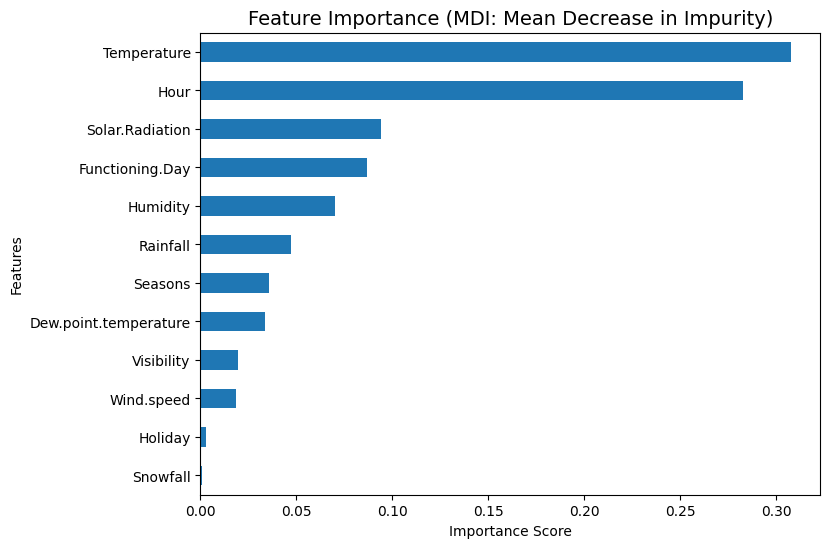

In [ ]:
# 랜덤 포레스트 학습
rf = RandomForestRegressor(n_estimators=128, random_state=42, n_jobs=-1)
rf.fit(X, y)

# MDI 중요도
mdi_importance = pd.Series(rf.feature_importances_, index=X.columns)

plt.figure(figsize=(8,6))
mdi_importance.sort_values().plot.barh()
plt.title("Feature Importance (MDI: Mean Decrease in Impurity)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

## 3. Permutation Importance (순열 중요도)

검증 데이터에서 특정 변수의 값을 무작위로 섞은 뒤 **성능이 얼마나 떨어지는지** 확인합니다.

- 성능 하락이 크다 → 그 변수가 중요한 역할
- 장점: 비선형 관계, 변수 상호작용도 반영 가능
- 단점: 계산 시간이 오래 걸림

### n_repeats 옵션이란?

`permutation_importance` 함수에서는 변수를 **한 번만 섞어서** 성능 변화를 볼 수도 있지만,<br>무작위로 섞는 과정에서 결과가 **우연에 의해 달라질 수** 있습니다.  

그래서 `n_repeats` 옵션을 사용하여 여러 번 섞어 평균을 냅니다.  

- `n_repeats=10` → 각 변수를 10번 무작위로 섞은 뒤, 성능 저하 값을 평균냄
- 반복 횟수를 늘릴수록 → 결과가 **더 안정적** (분산이 줄어듦)
- 단점: 반복 횟수가 많아질수록 **계산 시간이 오래 걸림**

따라서, 실습이나 교육에서는 **10회 반복** 정도로 충분하며, 연구나 실제 프로젝트에서는 **20회 이상** 반복하기도 합니다.


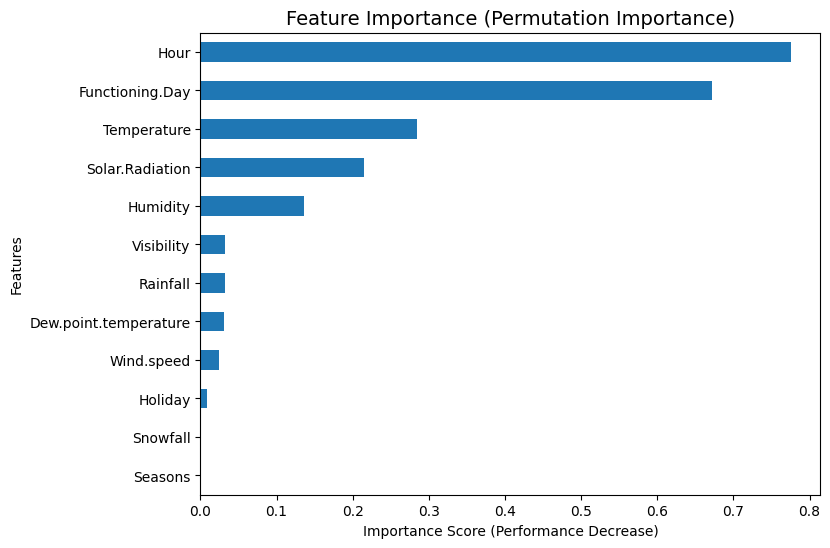

In [ ]:
# 학습/검증 데이터 분리
test_ratio = 0.2
test_size = int(len(df) * test_ratio)

X_train = X[:-test_size]
X_val   = X[-test_size:]
y_train = y[:-test_size]
y_val   = y[-test_size:]

# Permutation Importance 계산
perm_result = permutation_importance(
    rf, X_val, y_val,
    n_repeats=10,     # 여러 번 섞어 평균
    random_state=42,  # 재현성 확보
    n_jobs=-1         # CPU 병렬 처리
)

# 평균값만 정리
perm_importance = pd.Series(perm_result.importances_mean, index=X.columns)

# 시각화
plt.figure(figsize=(8,6))
perm_importance.sort_values().plot.barh()
plt.title("Feature Importance (Permutation Importance)", fontsize=14)
plt.xlabel("Importance Score (Performance Decrease)")
plt.ylabel("Features")
plt.show()

## 4. Drop-Column Importance (열 제거 중요도)

변수를 아예 제거한 모델과 포함한 모델을 학습시켜 **성능 차이**를 비교합니다.

- 성능 차이가 크다 → 해당 변수가 중요한 변수
- 장점: 가장 직관적
- 단점: 변수마다 모델을 새로 학습해야 하므로 계산 비용이 큼

Calculating Drop-Column Importances: 100%|██████████| 12/12 [01:09<00:00,  5.77s/it]


Seasons                 -0.040303
Solar.Radiation         -0.023774
Temperature             -0.006263
Dew.point.temperature   -0.004995
Wind.speed              -0.002638
Holiday                 -0.000254
Snowfall                 0.000145
Humidity                 0.014584
Rainfall                 0.019784
Visibility               0.044138
Hour                     0.263698
Functioning.Day          0.337537
dtype: float64


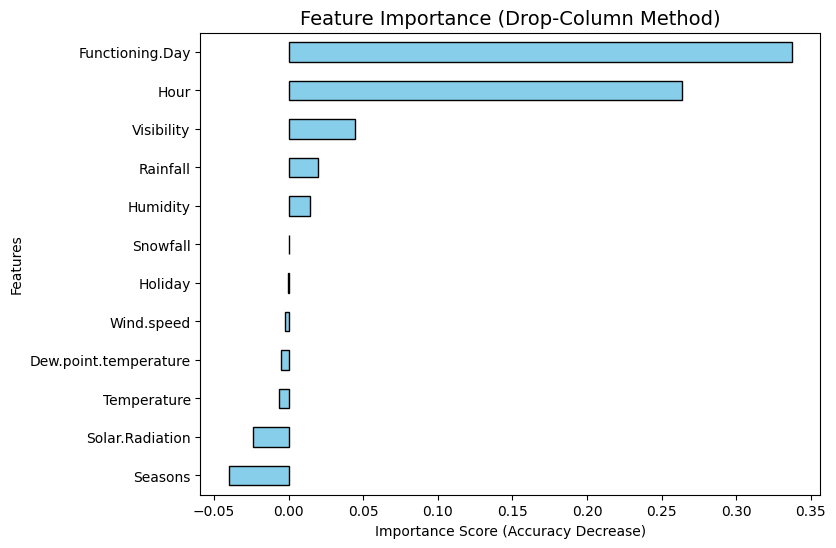

In [ ]:
from tqdm import tqdm  # 진행 상황 표시 (선택사항)

# Drop-Column Importance 계산 함수
def drop_column_importances(model, X_train, y_train, X_val, y_val):
    base_model = make_pipeline(model)
    base_model.fit(X_train, y_train)
    base_score = base_model.score(X_val, y_val)

    importances = {}
    for col in tqdm(X_train.columns, desc="Calculating Drop-Column Importances"):
        # 해당 컬럼 제거 후 모델 학습
        model_drop = make_pipeline(model)
        model_drop.fit(X_train.drop(columns=[col]), y_train)
        drop_score = model_drop.score(X_val.drop(columns=[col]), y_val)

        # 성능 차이 = Drop-Column Importance
        importances[col] = base_score - drop_score

    return pd.Series(importances).sort_values(ascending=True)

# 모델 정의
rf_model = RandomForestRegressor(n_estimators=128, random_state=42, n_jobs=-1)

# Drop-Column 중요도 계산
drop_importances = drop_column_importances(rf_model, X_train, y_train, X_val, y_val)

# 결과 출력
print(drop_importances)

# 시각화
plt.figure(figsize=(8,6))
drop_importances.sort_values().plot.barh(color="skyblue", edgecolor="black")
plt.title("Feature Importance (Drop-Column Method)", fontsize=14)
plt.xlabel("Importance Score (Accuracy Decrease)")
plt.ylabel("Features")
plt.show()

## 정리

- **상관계수 히트맵**: 단순 선형 관계만 반영 → 한계 존재
- **MDI**: 빠르고 직관적이지만 편향 가능
- **Permutation**: 변수 섞었을 때 성능 저하 → 비선형 관계까지 반영
- **Drop-Column**: 성능 차이를 직접 비교 → 가장 직관적이지만 계산 비용 큼

데이터 시각화를 통해 **세 가지 변수 중요도 방식의 차이**를 직접 확인하고, <br> 어떤 상황에서 어떤 방법이 더 적합한지 생각해 봅시다!

## 5. PDP & ICE with scikit-learn (Bike Sharing)

`pdpbox` 대신 **scikit-learn 내장 도구**로 PDP/ICE를 그립니다.

장점
- 회귀/분류 모두 안정적
- ICE(`kind="individual"`)와 PDP 평균선(`kind="average"`)을 한 번에 그릴 수 있음
- 2D PDP(예: Temperature × Hour)도 간단

아래에서
1) 데이터/모델 준비
2) Temperature 단변량 PDP+ICE
3) Hour 단변량 PDP+ICE
4) Temperature × Hour 2D PDP(등고선/히트맵)
순으로 진행합니다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

# 이미 df가 메모리에 있고, 'Rented.Bike.Count'가 타깃인 것으로 가정
# df = pd.read_csv(...)

# 1) X, y 분리
y = df['Rented.Bike.Count']
X = df.drop(columns=['Rented.Bike.Count'])

# 2) 숫자형만 사용(문자형이 섞여 있으면 PDP/ICE 그릴 때도 문제됩니다)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) < X.shape[1]:
    print("[Info] Non-numeric columns were dropped for modeling:",
          list(set(X.columns) - set(num_cols)))
X = X[num_cols]

# 3) 결측 처리(간단 전략: 제거)
X = X.dropna()
y = y.loc[X.index]

# 4) 학습/테스트 분리 및 모델 학습
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print(f"Train R²: {model.score(X_train, y_train):.3f}")
print(f"Test  R²: {model.score(X_test, y_test):.3f}")

# 5) 나중에 PDP/ICE에서 쓸 feature 이름 체크
features = X.columns.tolist()
print("Feature columns:", features[:8], "... (total:", len(features), ")")

[Info] Non-numeric columns were dropped for modeling: ['Date']
Train R²: 0.983
Test  R²: 0.859
Feature columns: ['Hour', 'Temperature', 'Humidity', 'Wind.speed', 'Visibility', 'Dew.point.temperature', 'Solar.Radiation', 'Rainfall'] ... (total: 12 )


## Temperature — PDP & ICE

### ICE (Individual Conditional Expectation)
- **정의**: 특정 변숫값(여기서는 Temperature)을 x축에서 **한 샘플씩 변화**시킬 때, 그 샘플의 **예측값 변화 곡선**을 그린 그래프.
- **무엇을 보여주나**: 개별 데이터의 **반응 차이(이질성)** — 평균에 가려진 서로 다른 패턴을 드러냄.
- **읽는 요령**
  - 선들이 **한 방향으로 고르게** 움직이면 → 대부분 같은 반응(일관성 높음)
  - 선들이 **엉키거나 교차**하면 → 데이터마다 반응 상이(이질성/상호작용 신호)
- **언제 유용한가**
  - 평균(PDP)과 **다른 반응을 보이는 집단** 탐지
  - **편향·특이치** 영향 점검
- **주의점**: 선이 많아 복잡할 수 있음 → **투명도(alpha)** 낮추기 또는 **표본 일부만** 표시

### PDP (Partial Dependence Plot)
- **정의**: Temperature를 변화시킬 때 **전체 평균 예측값**이 어떻게 변하는지 보여주는 **대표 곡선**.
- **무엇을 보여주나**: 데이터 전반의 **평균적 추세**(증가/감소/포화/임계 구간 등).
- **읽는 요령**
  - **기울기**: 민감도(가파를수록 영향 큼)
  - **굽은 구간**: 비선형 관계(효과의 체감/증폭)
  - **평평한 구간**: 영향 적음(민감도 낮음)
- **언제 유용한가**
  - 변수의 **전반적 영향 방향·세기**를 빠르게 요약
  - **보고·설명용** 단일 그림이 필요할 때
- **주의점**: 평균이므로 **소수 집단의 다른 반응**을 가릴 수 있음 → ICE와 **함께** 해석 권장

### ICE vs PDP 한눈 비교
- **초점**: ICE = 개별 반응 / PDP = 평균 반응  
- **장점**: ICE = 이질성 탐지 / PDP = 요약·전달력  
- **권장 표시**: `kind="both"`로 **ICE(얇은 다수의 선) + PDP(굵은 평균선)** 동시 제시

### 해석 팁 (Temperature 예시)
- ICE 선들이 대체로 **상향**이면: Temperature↑ → 예측 수요↑ (일관된 양의 효과)
- ICE가 **두 무리로 갈라지면**: 다른 변수(예: Hour·Holiday)와의 **상호작용** 신호
- PDP가 **완만해지는 구간**: **포화/임계** — 더 높여도 효과 증가폭이 작아짐

<Figure size 700x500 with 0 Axes>

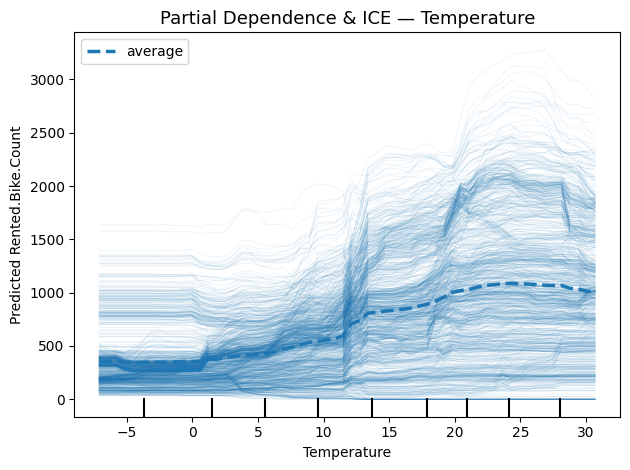

In [ ]:
plt.figure(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    model, X, features=['Temperature'],
    kind="both",             # "average" | "individual" | "both"
    grid_resolution=60,      # x축 분해능
    ice_lines_kw={"alpha":0.10},   # ICE 선 투명도
    pd_line_kw={"linewidth":2.5},  # PDP 평균선 두께
)
plt.title("Partial Dependence & ICE — Temperature", fontsize=13)
plt.xlabel("Temperature")
plt.ylabel("Predicted Rented.Bike.Count")
plt.tight_layout()
plt.show()

## Hour — PDP & ICE

- 출퇴근 시간(예: 8시, 18시) 주변에서 수요가 뚜렷이 변하는지
- 심야/새벽 시간대의 저수요 구간은 어디인지

ICE로 개별 곡선의 이질성(패턴 차이)도 확인합니다.

<Figure size 700x500 with 0 Axes>

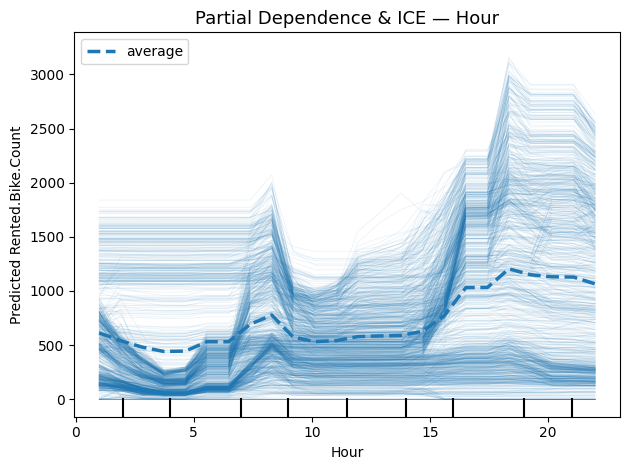

In [ ]:
plt.figure(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    model, X, features=['Hour'],
    kind="both",
    grid_resolution=24,
    ice_lines_kw={"alpha":0.10},
    pd_line_kw={"linewidth":2.5},
)
plt.title("Partial Dependence & ICE — Hour", fontsize=13)
plt.xlabel("Hour")
plt.ylabel("Predicted Rented.Bike.Count")
plt.tight_layout()
plt.show()

## Temperature × Hour — 2D PDP

**두 변수의 상호작용**(interaction)을 2D로 시각화합니다.  
- 특정 시간대에 온도가 높아질수록 수요가 어떻게 반응하는지
- 같은 온도라도 시간대에 따라 예측이 달라지는지

등고선/히트맵 형태로 해석합니다.

<Figure size 700x500 with 0 Axes>

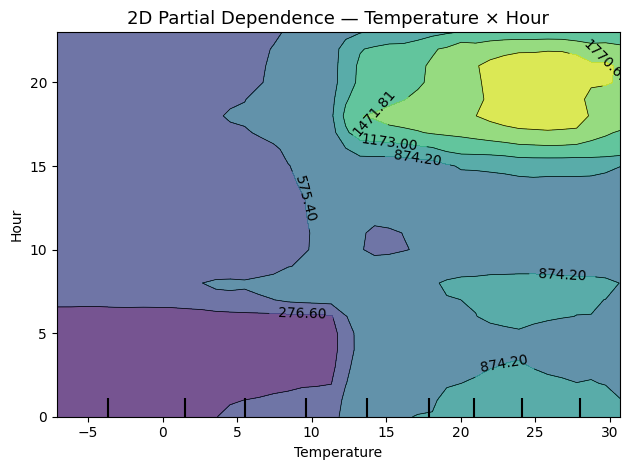

In [ ]:
fig = plt.figure(figsize=(7,5))
disp = PartialDependenceDisplay.from_estimator(
    model, X,
    features=[('Temperature','Hour')],
    kind="average",
    grid_resolution=40
)
# 디스플레이 객체는 서브플롯을 반환합니다.
ax = disp.axes_[0,0]
ax.set_title("2D Partial Dependence — Temperature × Hour", fontsize=13)
ax.set_xlabel("Temperature")
ax.set_ylabel("Hour")
plt.tight_layout()
plt.show()

## 해석 가이드

- **Temperature (PDP/ICE)**: 기온 상승에 따라 예측 수요가 증가/포화/감소하는 구간을 파악  
- **Hour (PDP/ICE)**: 출퇴근 시간대 피크, 심야 저수요 구간 확인  
- **Temperature × Hour (2D PDP)**:
  - "몇 시에" + "어떤 기온"에서 수요가 높은지
  - 시간대에 따라 온도 민감도가 달라지는지(상호작용)

팁: 범주형(예: Holiday, Seasons)이 문자열이면 **원-핫 인코딩** 후 PDP/ICE를 그리세요.